# QUANTITATIVE STRATEGY CASE INTERVIEW

## Section 2 | Data Modeling
HDB wants to know if a resale flat transaction fits market expectations. Your task is to create statistical
models to answer the following questions.

---

*Question A*  
Predict a resale flat price’s transaction price in 2014. Use the following characteristics
flat type, flat age and town. Propose and implement a minimum of three models, select the best
model, and explain the reasons for your choice.

### Data Wrangling

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# some settings
sns.set_style("darkgrid")

In [5]:
# Import train test split
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.pipeline import make_pipeline

In [6]:
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [6]:
# save the model
from joblib import dump, load

In [8]:
# extract dataset
df = pd.read_csv('hdb_resale.csv')

/Users/Ju/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Add the sample info to the y_test
- Flat type: 4 ROOM
- Town: Yishun
- Flat Model: New Generation
- Storey Range: 10 to 12
- Floor Area (sqm): 91
- Lease Commence Date: 1984
- Resale Price: 550,800  



In [8]:
test = pd.DataFrame([['YISHUN','4 ROOM','New Generation',91,'NA',550800,'2017-11-01',66,'1984-01-01','10 TO 12','NA',10,12,11,11]], columns=df.columns.to_list(), index=[999999])

In [9]:
df = df.append(test,ignore_index=True)
# now the test portion from section B is added and any feature engineering will be done together

### Data types

In [10]:
# change to time format for date columns
for x in ['month','lease_commence_date']:
    df[x] = pd.to_datetime(df[x])

There is no missing values to be considered

## EDA

In [12]:
numeric_feat =[col for col in df.columns if df[col].dtypes != 'O'and col not in ['_id']]
discrete_feat = [col for col in numeric_feat if len(df[col].unique())<25 and col not in ['_id']]
continuous_feat = [col for col in numeric_feat if col not in discrete_feat and col not in ['_id']]
categorical_feat = [col for col in df.columns if df[col].dtypes == 'O']

#### Distribution Comparison - Discrete

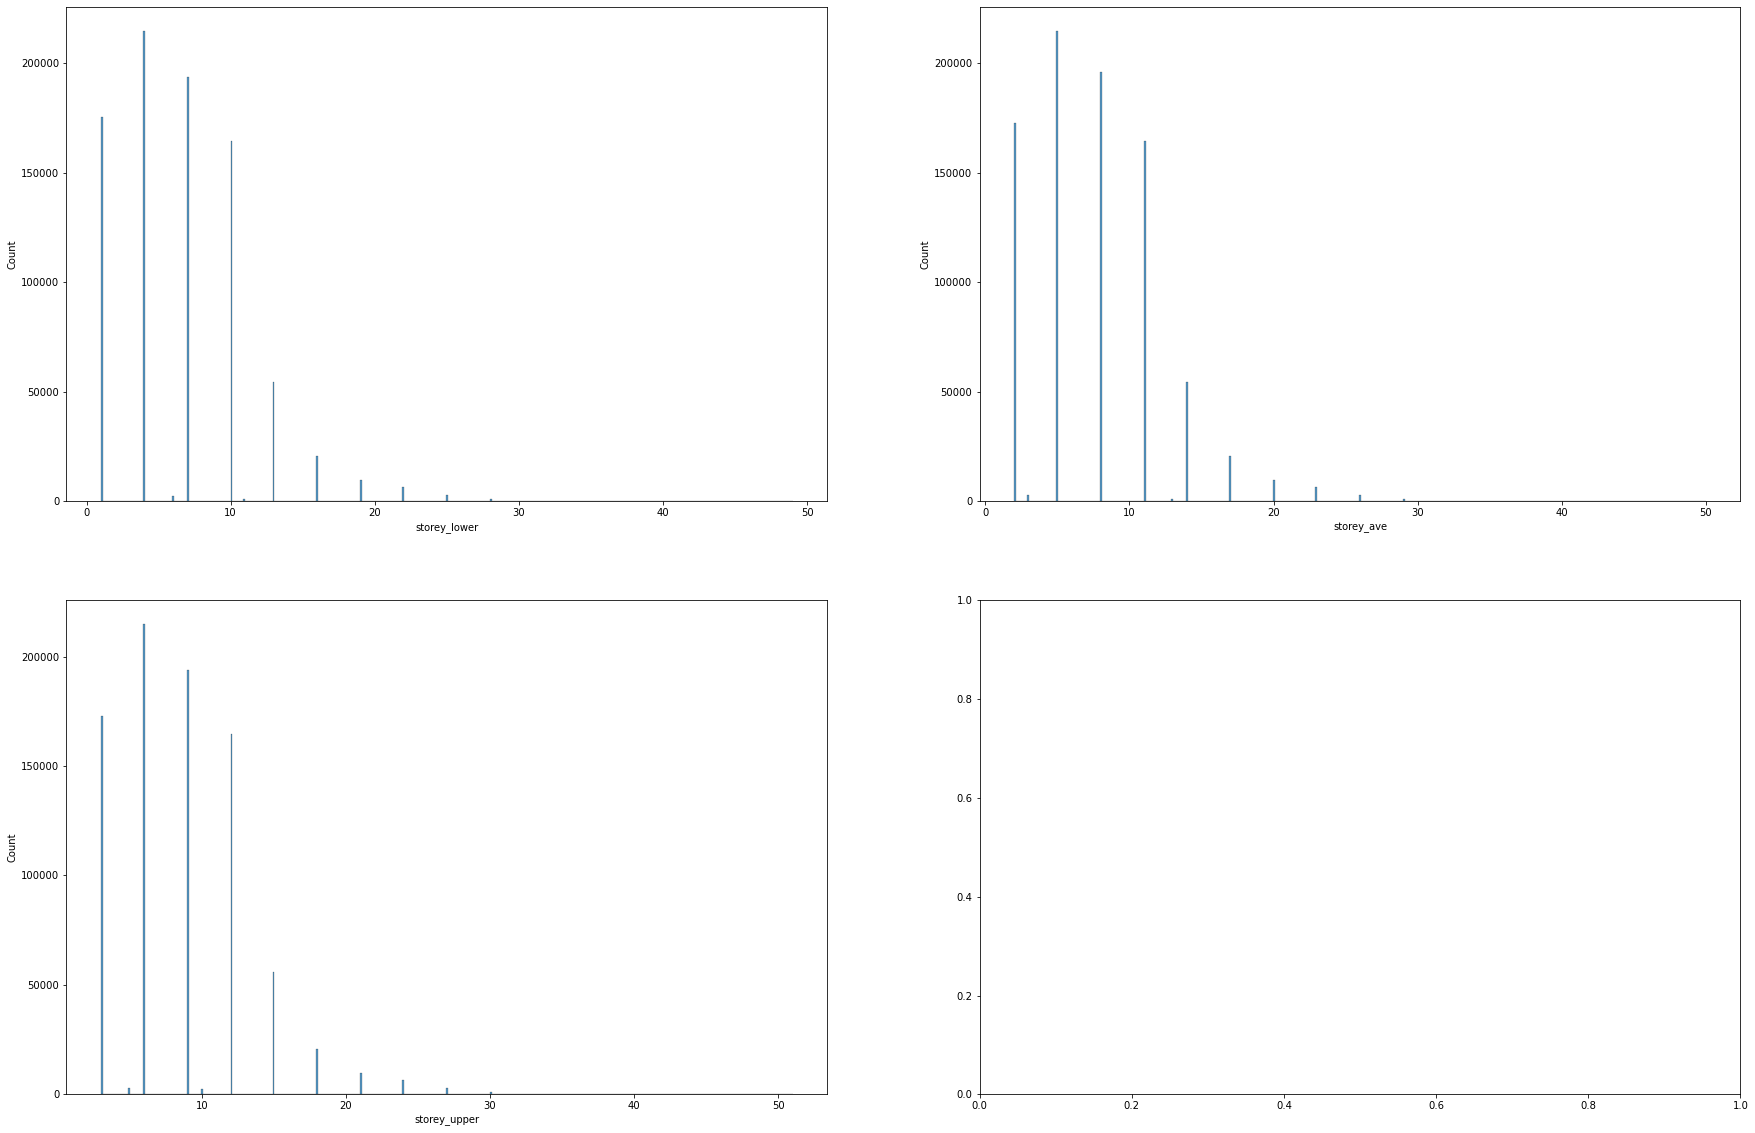

In [15]:
# set the number of cols needed
cols = 2   
# rows is based on cols and features plot
rows = int(len(discrete_feat)/cols+1)

f, axes = plt.subplots(rows, cols, figsize=(30, 20), sharex=False)
for i, feature in enumerate(discrete_feat):
    sns.histplot(data=df, x = feature,ax=axes[i%rows, i//rows])

####  Distribution Comparison - Continuous

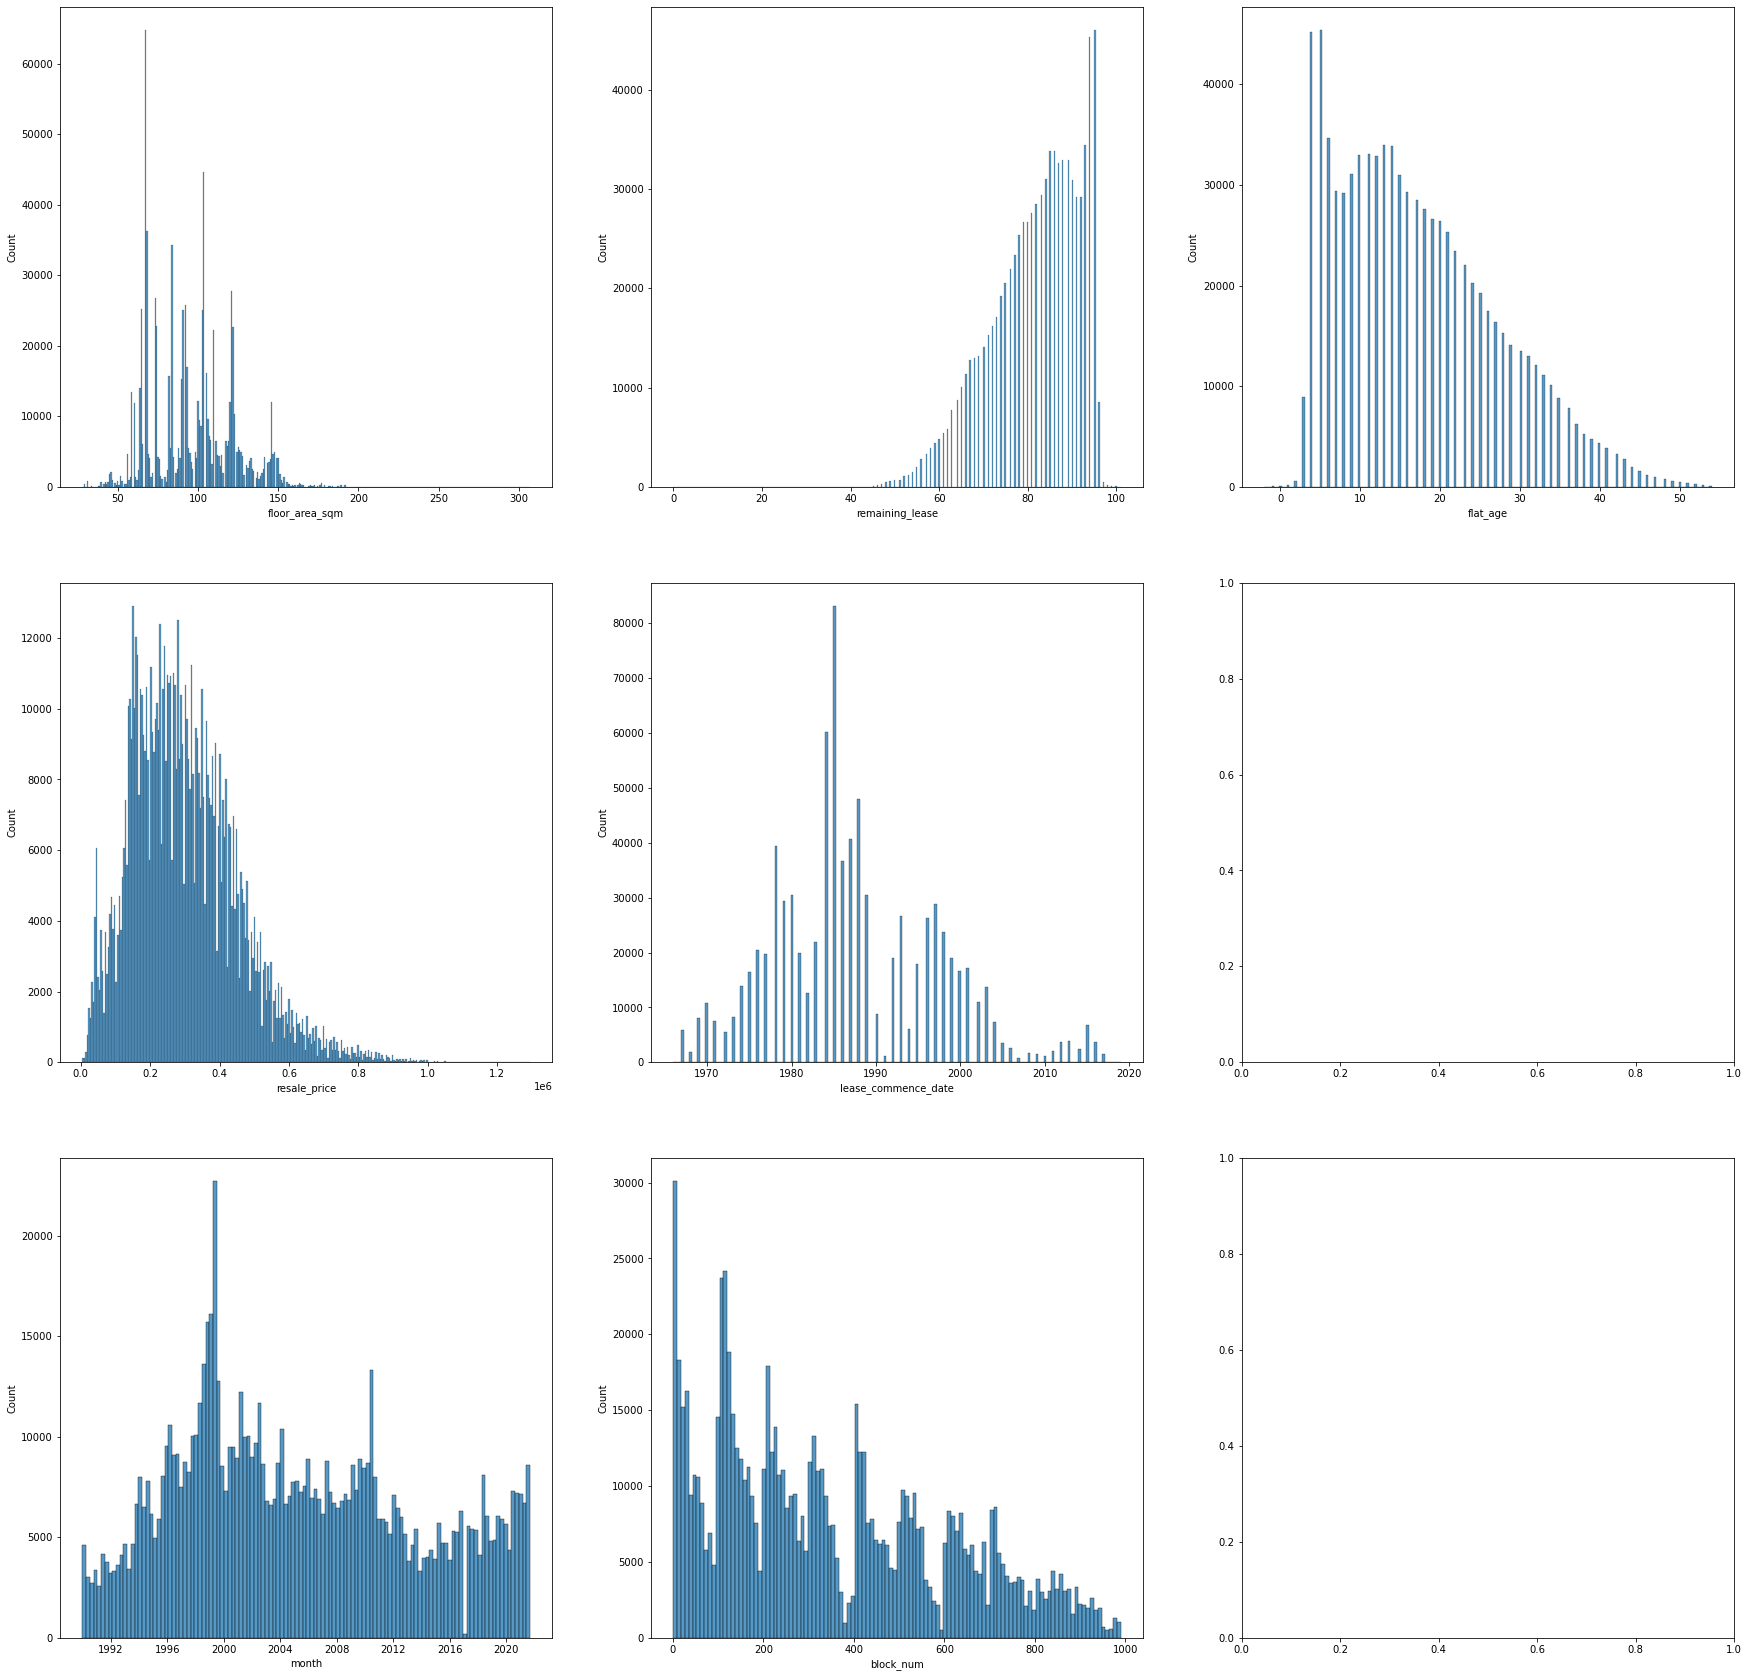

In [16]:
cols = 3
rows = int(len(continuous_feat)/cols+1)

f, axes = plt.subplots(rows,cols, figsize=(30, 30), sharex=False)
for i, feature in enumerate(continuous_feat):
    sns.histplot(data=df, x = feature,ax=axes[i%rows, i//rows]) 

Resale price appears to be normal, however for this analysis methods like Linear Regression will be applied, so this data will be scaled to ensure more symmetric and normal distribution.

#### Linearity Check

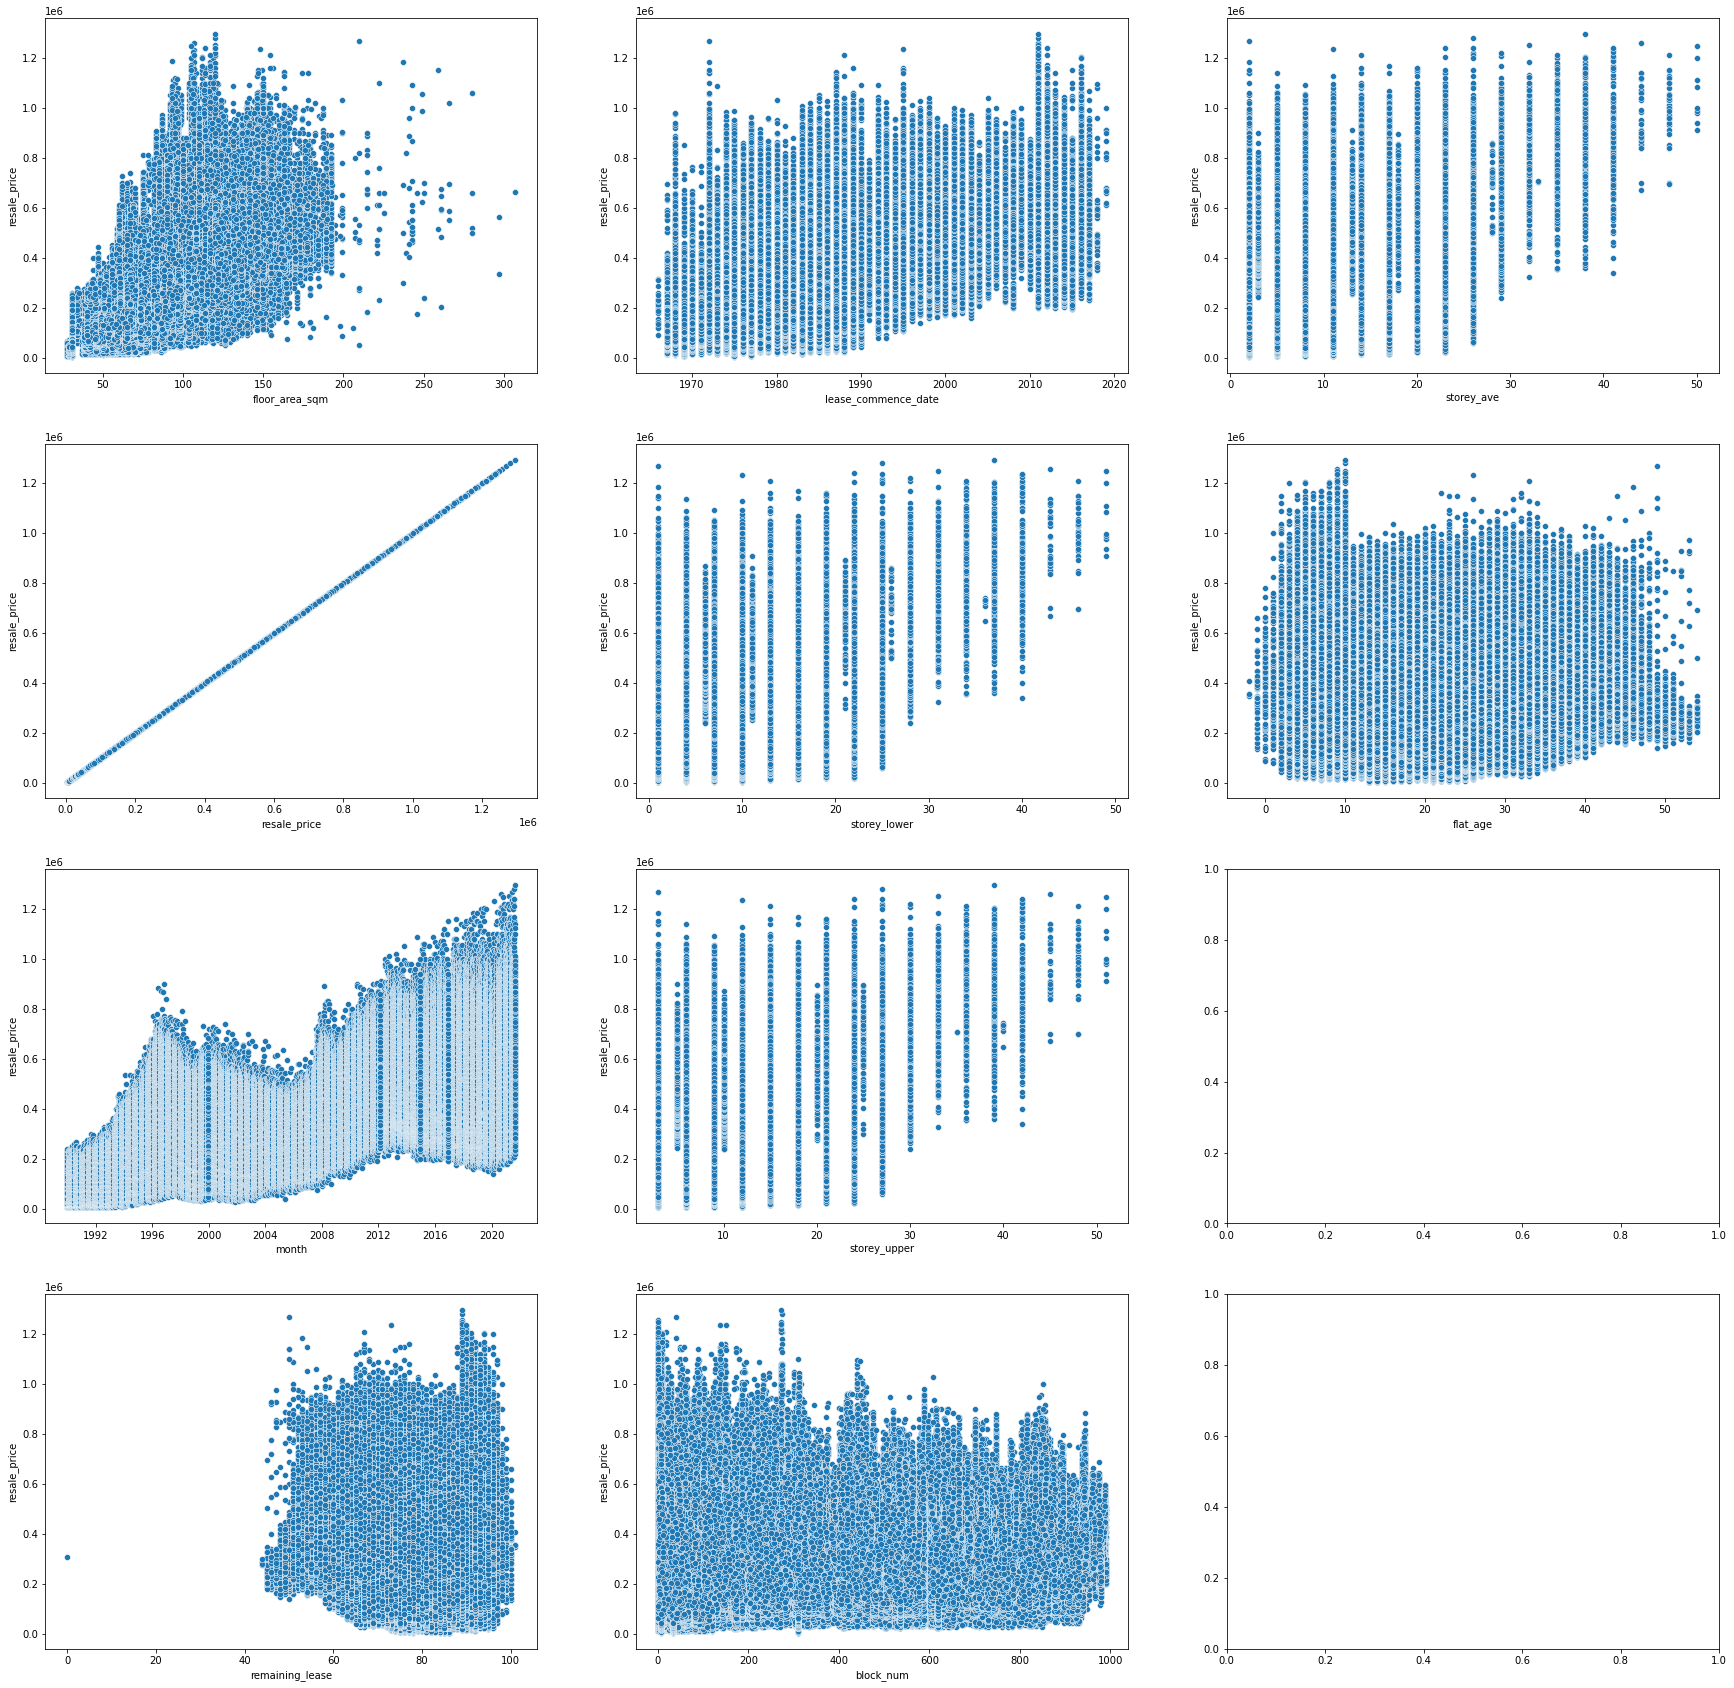

In [17]:
cols = 3
rows = int(len(numeric_feat)/cols+1)

f, axes = plt.subplots(rows, cols , figsize=(30, 30), sharex=False)
for i, feature in enumerate(numeric_feat):
    sns.scatterplot(data=df, x =feature ,y='resale_price',ax=axes[i%rows, i//rows])

***outliers***  
there is an outlier in the remaining lease. this value is likely will be an error but the remaining lease will be recalculated based on a 99 year lease and the month of transactions

In [54]:
df[df['remaining_lease']==0]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,block,storey_lower,storey_upper,block_num,storey_ave,flat_age
81126,ANG MO KIO,3 ROOM,New Generation,73.0,ANG MO KIO AVE 3,310000.0,2020-12-01,0.0,1979-01-01,01 TO 03,425,1,3,425,2.0,41


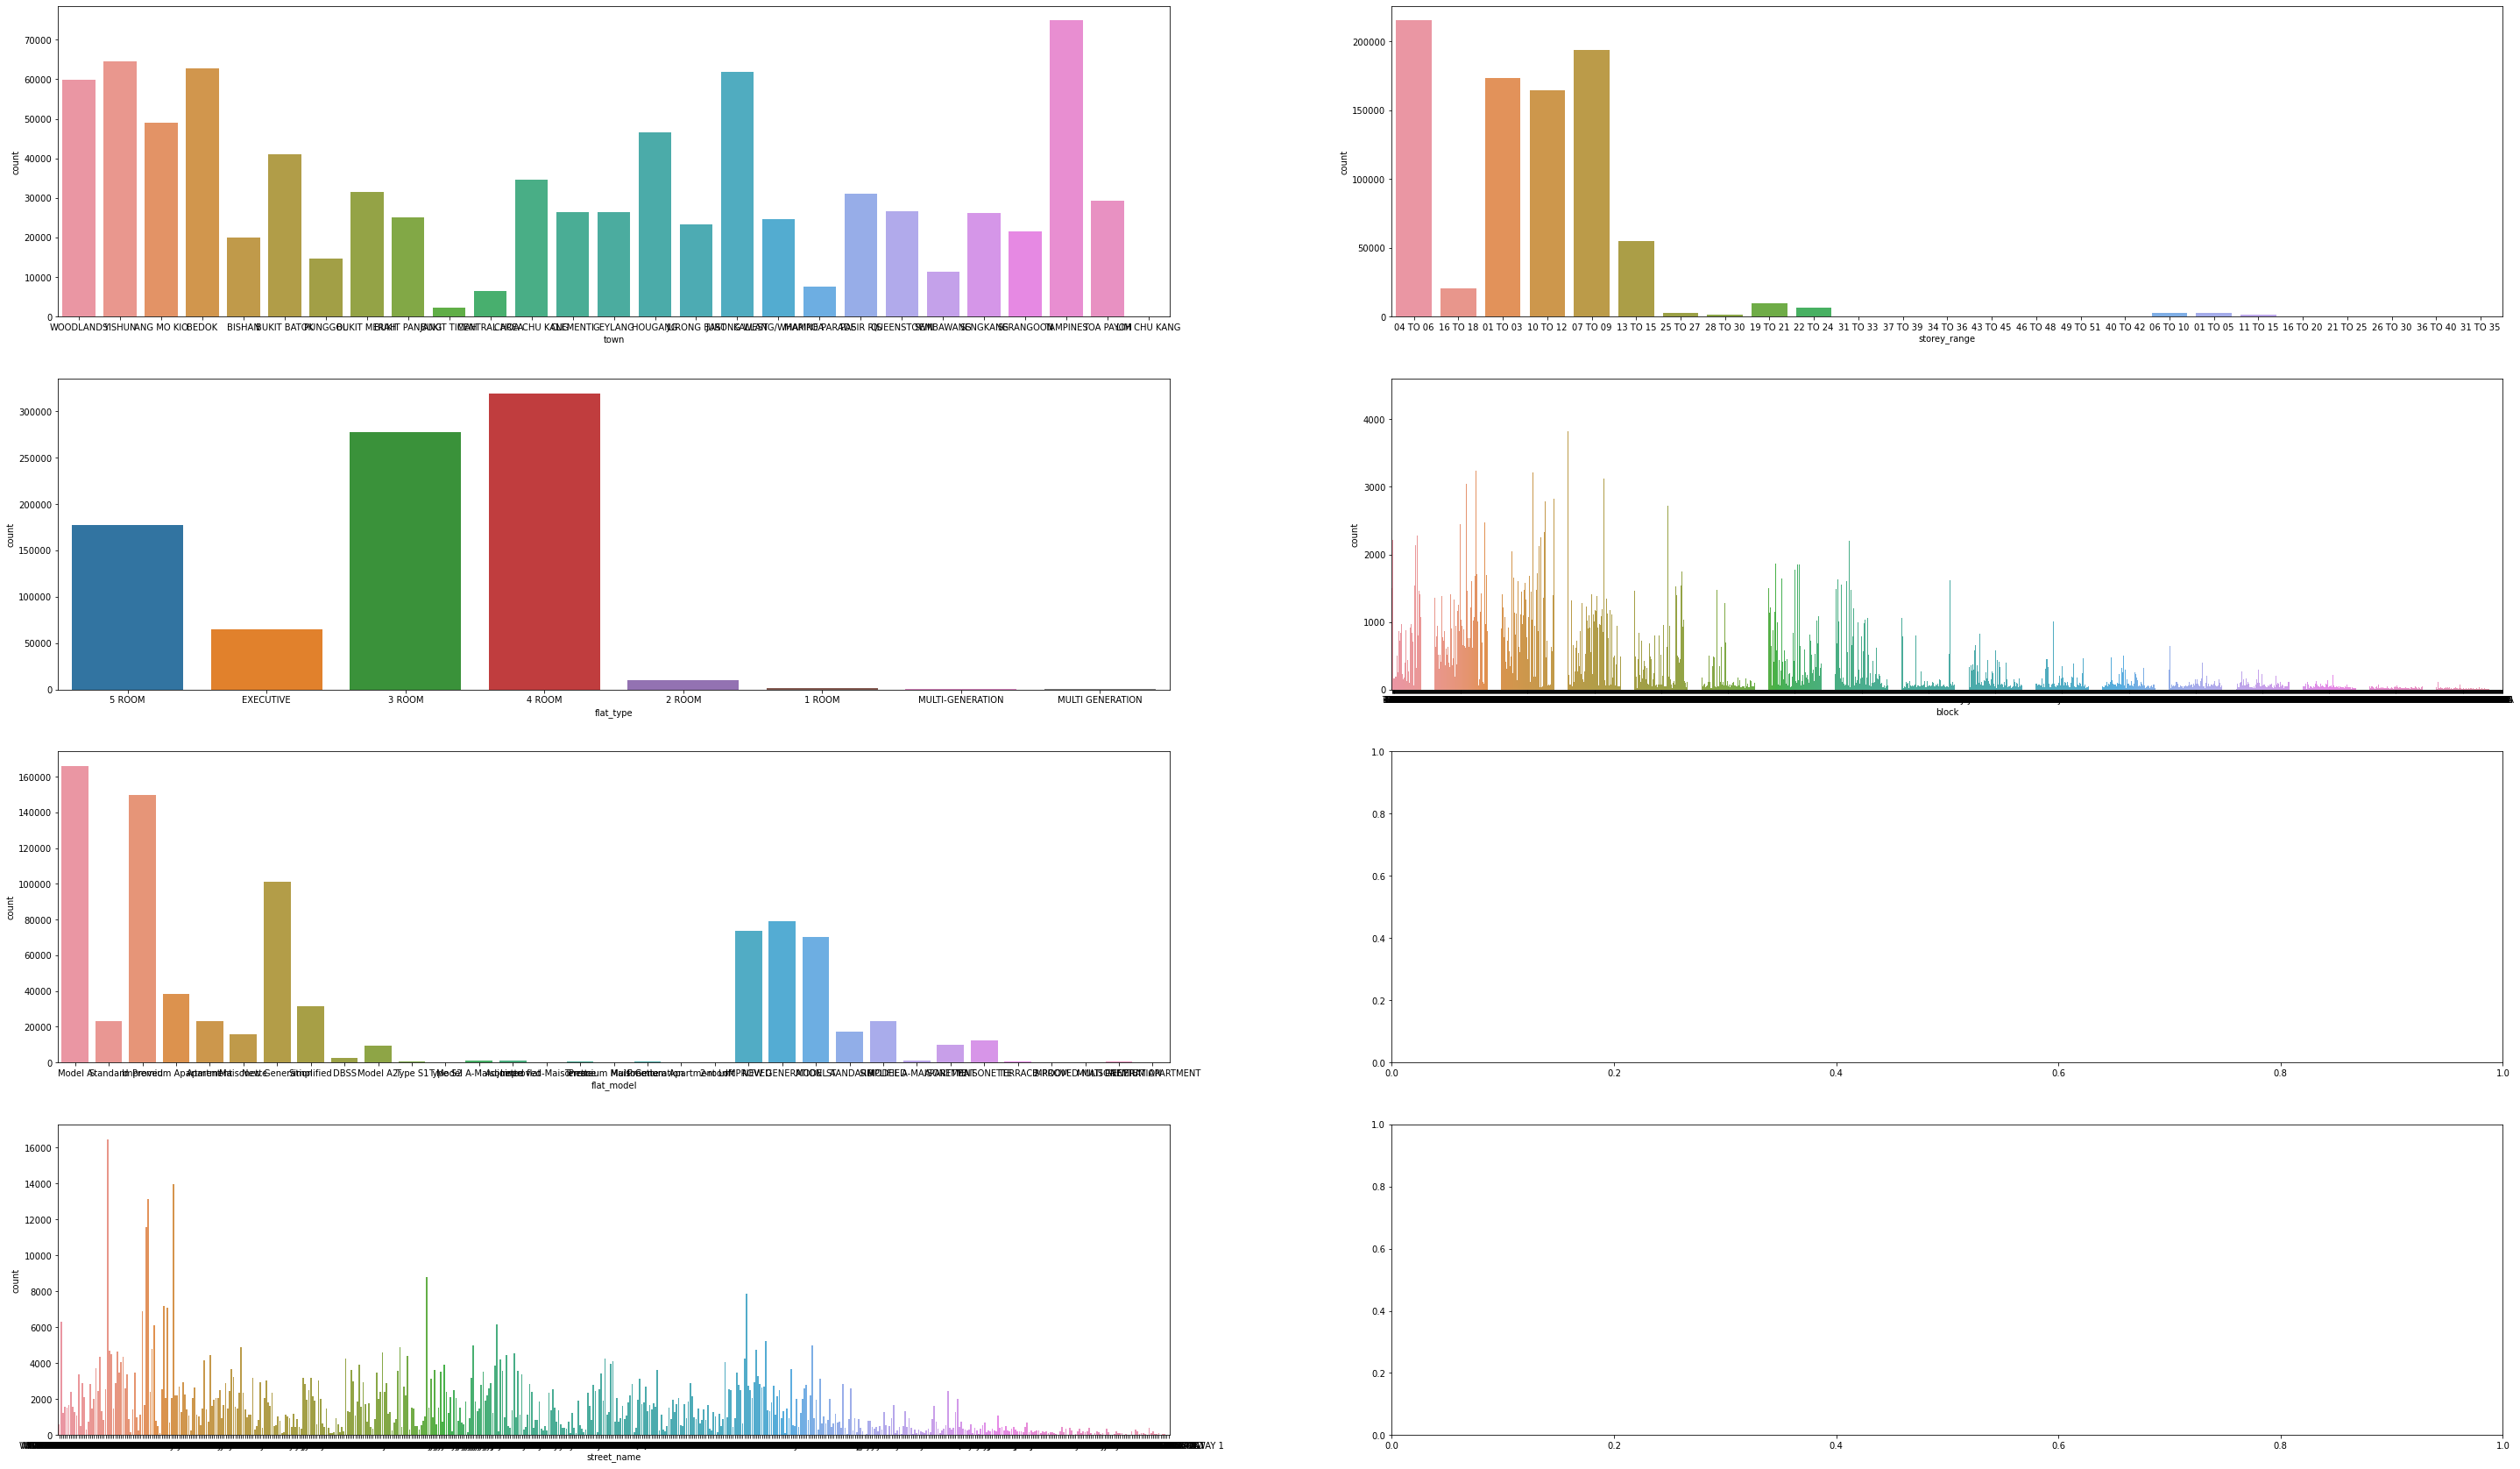

In [18]:
cols = 2
rows = int(len(categorical_feat)/cols+1)

f, axes = plt.subplots(rows, cols, figsize=(50, 30), sharex=False)
for i, feature in enumerate(categorical_feat):
    sns.countplot(data = df, x = feature, ax=axes[i%rows, i//rows])

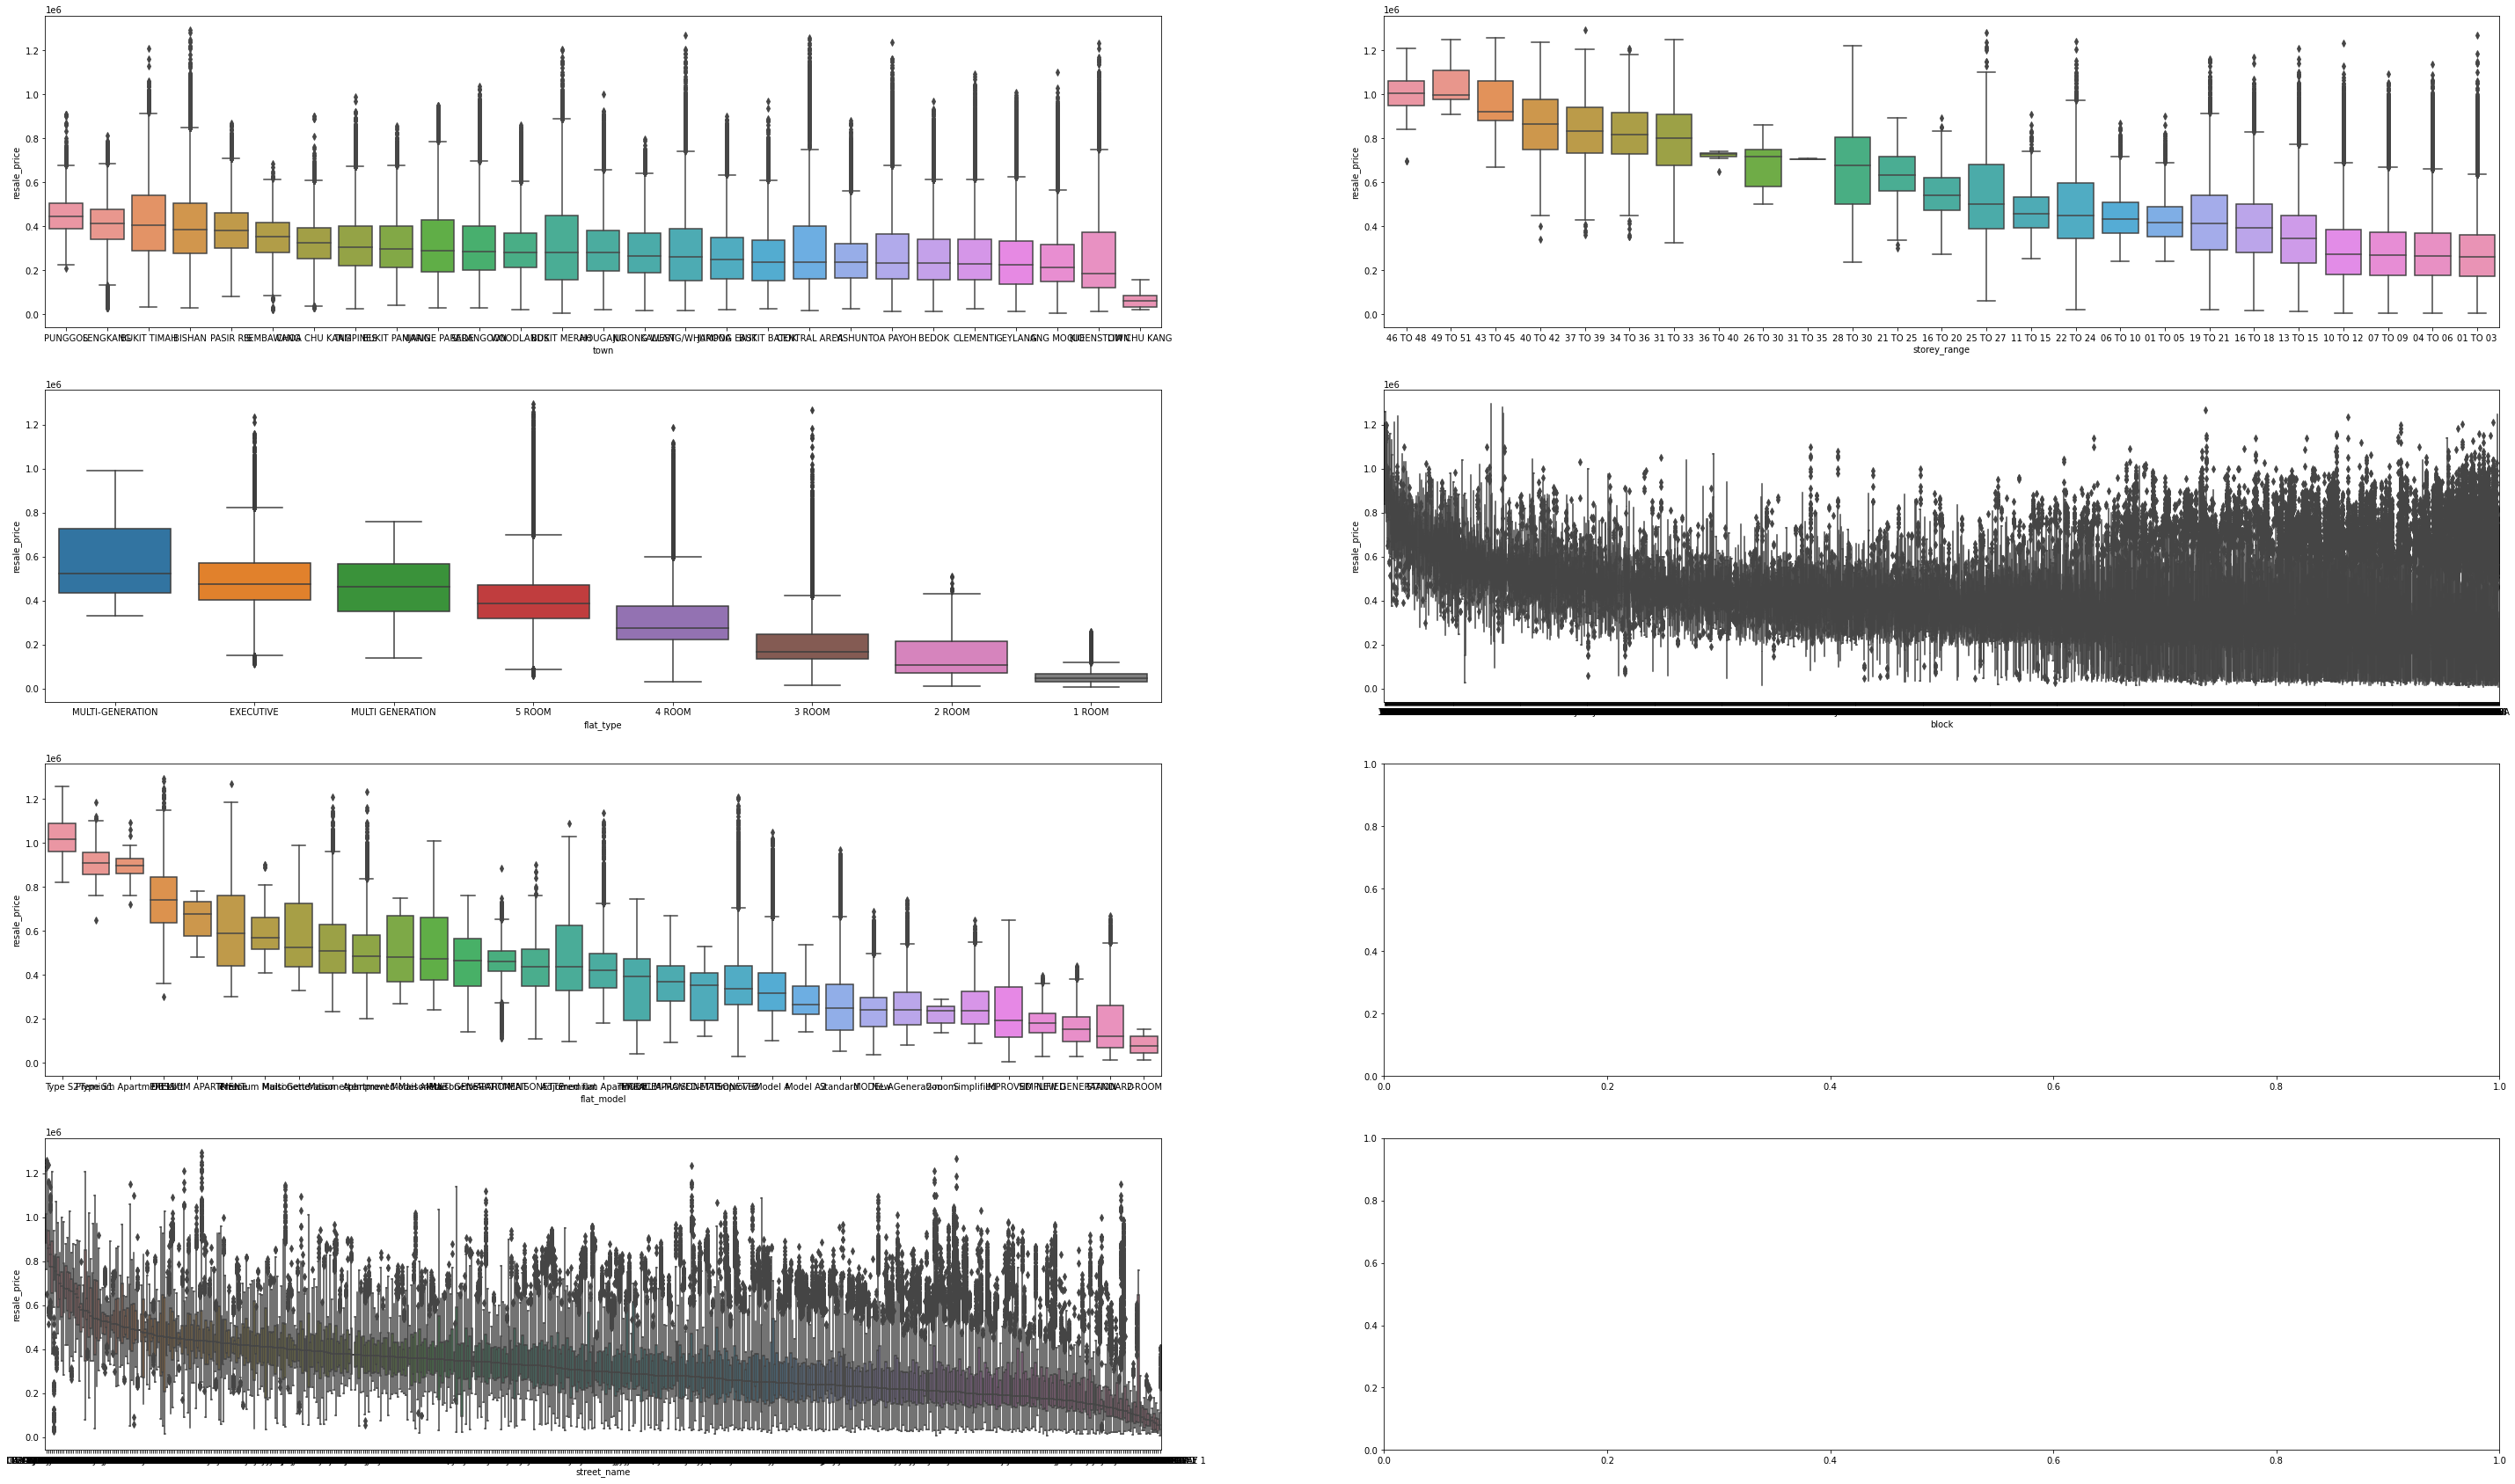

In [21]:
cols = 2
rows = int(len(categorical_feat)/cols+1)

f, axes = plt.subplots(rows, cols , figsize=(50, 30), sharex=False)
for i, feature in enumerate(categorical_feat):
    sort_list = sorted(df.groupby(feature)['resale_price'].median().items(), key= lambda x:x[1], reverse = True)
    order_list = [x[0] for x in sort_list ]
    sns.boxplot(data = df, x = feature, y='resale_price', order=order_list, ax=axes[i%rows, i//rows])
plt.show()

- flat_type has some variation although they are very close to each other, 3-5 room flats have a large variance
- remaining_lease (flat age), remaining lease will be considered as age because all HDB have a 99-year lease, this it will have a opposite correlation to age. Also this varaible should have a positive correlation to the housing price which may be easier to explain.
- town - PUNGGOL and LIM CHU KANG seem to have the largest and smallest variance but they have a similarity in being far from the city. These relationships may become more clear when more than only one feature is considered.

### Correlations

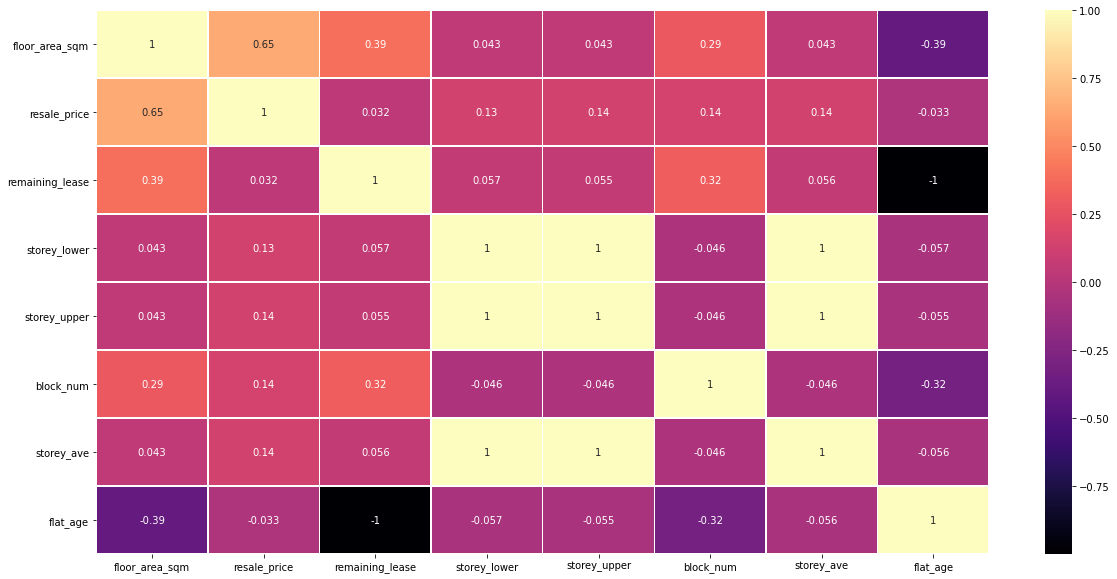

In [122]:
training_corr = df.corr(method='spearman')
plt.figure(figsize=(20,10))
sns.heatmap(training_corr, cmap="magma", linewidths=.5, annot=True);

white squares are related because they were engineered and are related. so too for remaining_lease and flat_age
other corelated features of note are:  
    - flat_age vs floo_area_sqm (remaining_lease): flats are getting smaller over time  
    - resale_price is sensative to size which is expected and storey

---

## Question 2 Section A answer:

We focus on 2014 transacted prices to remove the consideration of price inflation over time and make an assumption that the price variation within the year is not significant
- town, 
- age (remaining_lease)
- flat_type 

and drop all other columns

In [12]:
df_2014 = df[df['month'].dt.year ==2014]
df_2014 = df_2014[['resale_price','remaining_lease','flat_type','town']]

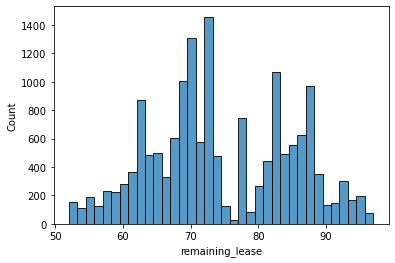

In [29]:
sns.histplot(data=df_2014, x = 'remaining_lease') ;

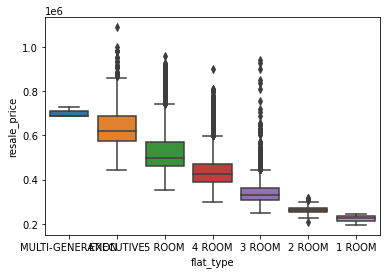

<Figure size 7200x2160 with 0 Axes>

In [147]:
sort_list = sorted(df_2014.groupby('flat_type')['resale_price'].median().items(), key= lambda x:x[1], reverse = True)
order_list = [x[0] for x in sort_list ]
sns.boxplot(data = df_2014, x = 'flat_type', y='resale_price', order=order_list)
plt.figure(figsize=(100, 30))
plt.show()

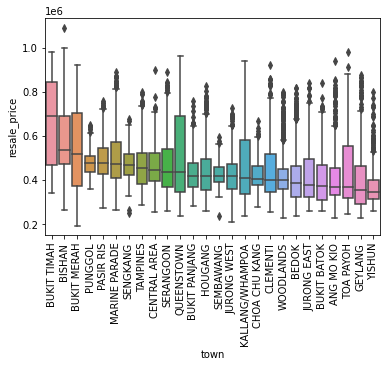

<Figure size 7200x2160 with 0 Axes>

In [154]:
sort_list = sorted(df_2014.groupby('town')['resale_price'].median().items(), key= lambda x:x[1], reverse = True)
order_list = [x[0] for x in sort_list ]
sns.boxplot(data = df_2014, x = 'town', y='resale_price', order=order_list)
plt.xticks(rotation='vertical')
plt.figure(figsize=(100, 30))
plt.show();

In [159]:
df_2014.dtypes

resale_price       float64
remaining_lease    float64
flat_type           object
town                object
dtype: object

## skewness

In [42]:
# check the skew of all numerical features
df_2014.remaining_lease.skew()

0.08700999751559986

there is apositive skew but it is slight in the remaining_lease

In [44]:
power = PowerTransformer(method='box-cox', standardize=True)
df_2014[['remaining_lease']] = power.fit_transform(df_2014[['remaining_lease']])

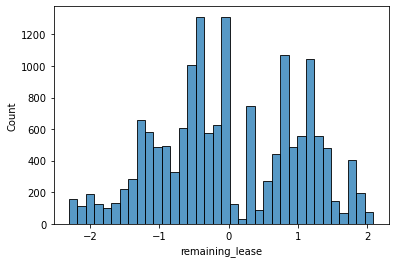

In [47]:
sns.histplot(data=df_2014, x = 'remaining_lease') ;

### Get dummies

In [41]:
df_2014 = pd.get_dummies(df_2014).reset_index(drop=True)
df_2014.shape

(16096, 35)

there is still more data than columns, this is still a good format for regression models

In [172]:
# create csv for future use
df_2014.to_csv('./data/df_2014.csv',index=False)

In [49]:
df_2014.head()

,resale_price,remaining_lease,flat_type_1 ROOM,flat_type_2 ROOM,flat_type_3 ROOM,flat_type_4 ROOM,flat_type_5 ROOM,flat_type_EXECUTIVE,flat_type_MULTI-GENERATION,town_ANG MO KIO,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,328000.0,-1.109673,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,285000.0,-2.302793,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,285000.0,-2.302793,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,285000.0,-2.078046,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,288000.0,-1.856982,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create train and test data

In [51]:
len(df_2014)

16096

In [42]:
# split to X and y
X = df_2014.drop(columns=['resale_price'])
y = np.log1p(df_2014['resale_price'])

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=42)

In [43]:
pre_precessing_pipeline = make_pipeline(RobustScaler(),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14486, 34)
(1610, 34)


### OLS Baseline

Create a baseline with OLS

#### OLS Baseline fit

In [44]:
ols=LinearRegression()
ols.fit(X_train, y_train)

In [61]:
print(f'train rmse: {ols_scores.mean():.4f}')

train rmse: -0.0116


In [53]:
y_pred = np.expm1(ols.predict(X_train))
ols_mse = mean_squared_error(np.expm1(y_train), y_pred)
print(f'train rmse\t\t{ols_mse**.5}')

train rmse		51917.32940619709


#### OLS Baseline Evaluating Model

In [55]:
y_pred = np.expm1(ols.predict(X_test))
ols_mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'train rmse\t\t{ols_mse**.5}')

train rmse		53436.403333178554


In [56]:
ols_coef = pd.DataFrame(ols.coef_, index = X.columns.to_list())
ols_coef.columns = ['ols_coef']
ols_coef.sort_values(by='ols_coef',key=lambda x: abs(x),ascending=False)

,ols_coef
flat_type_MULTI-GENERATION,9.121473e+10
flat_type_EXECUTIVE,9.121473e+10
flat_type_5 ROOM,9.121473e+10
flat_type_4 ROOM,9.121473e+10
flat_type_3 ROOM,9.121473e+10
flat_type_2 ROOM,9.121473e+10
flat_type_1 ROOM,9.121473e+10
town_BUKIT TIMAH,6.595388e+09
town_MARINE PARADE,6.595388e+09
town_CENTRAL AREA,6.595388e+09


Coefficients show that OLS just groups the flat_type, remaining_lease and town then gives them the same coefficient magnitude

###  Lasso

#### Lasso fit

In [62]:
lasso_cv = LassoCV(cv=5,n_jobs=-1)
lasso_cv.fit(X_train,y_train)
lasso_cv_scores = cross_val_score(lasso_cv, X_train, y_train, cv=10, n_jobs=-1,scoring='neg_mean_squared_error')

In [63]:
print(f'train rmse: {abs(lasso_cv_scores.mean())**.5:,.4f}')

train rmse: 0.1081


In [65]:
y_pred = np.expm1(lasso_cv.predict(X_train))
lasso_cv_mse = mean_squared_error(np.expm1(y_train), y_pred)
print(f'train rmse\t\t{lasso_cv_mse**.5:,.0f}')

train rmse		52,265


### Lasso Evaluating Model

In [66]:
y_pred = np.expm1(lasso_cv.predict(X_test))
lasso_cv_mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'test rmse\t\t{lasso_cv_mse**.5:,.0f}')

test rmse		53,706


In [114]:
lasso_cv_coef = pd.DataFrame(lasso_cv.coef_, index = X.columns.to_list())
lasso_cv_coef.columns = ['lasso_coef']
lasso_cv_coef.sort_values(by='lasso_coef',key=lambda x: abs(x),ascending=False)[:20]

,lasso_coef
flat_type_1 ROOM,-291775.141365
flat_type_2 ROOM,-207939.339280
flat_type_EXECUTIVE,207601.071155
town_BUKIT TIMAH,197361.434150
town_MARINE PARADE,159357.740449
flat_type_MULTI-GENERATION,152811.356053
town_QUEENSTOWN,133008.604279
town_BUKIT MERAH,132905.702743
town_SEMBAWANG,-129076.972774
town_CENTRAL AREA,116840.455251


Lasso is used as a regularisation model to reduce the number of coeffients. But the result does not remove any feature. But compared to OLS it does differentiate the different flat_types and town

### Random Forest

This allows for ensemble, random subset selection and Bagging

In [67]:
rf = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [5,100,200,700],
    'max_depth': [1,6,100]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=10,n_jobs=-1,scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 6, 100],
                         'n_estimators': [5, 100, 200, 700]},
             scoring='neg_mean_squared_error')

In [68]:
gs.best_params_

{'max_depth': 100, 'n_estimators': 700}

In [72]:
print(f'train rmse: {abs(gs.best_score_)**.5:.4f}')

train rmse: 0.0826


In [70]:
y_pred = np.expm1(gs.predict(X_train))
gs_mse = mean_squared_error(np.expm1(y_train), y_pred)
print(f'train rmse\t\t{gs_mse**.5:,.0f}')

train rmse		34,787


### Random Forest Evaluating Model

In [71]:
y_pred = np.expm1(gs.predict(X_test))
gs_mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'test rmse\t\t{gs_mse**.5:,.0f}')

test rmse		38,133


In [171]:
rf1 = RandomForestRegressor(random_state=42, max_depth=100,n_estimators=400)
rf1.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, n_estimators=400, random_state=42)

### Section 2. A Conclusion

The best model will be chosen based on the *lowest Cross-Validated train data root mean squeared error*, then the test score is used as reference.

OLS is set as the baseline, because it is the most inclusive but is not the most flexible either.  
- if there is more opportunity, polynomial relationships could be added
- Lasso is used because of regularisation to reduce coefficients although it did not affect performance and all the coefficients were found to be significant even though this method is considered to be aggressive.  
- alpha is automatically chosen
    
***Random Forest is chosen as the best model.***

*Reasons*
- bagging aggregates a close estimate of the relationships between coefficients
- random subset selection. although there are only 3 main features, there is localised relationships for example between towns

In [168]:
forest_importances = pd.Series(rf1.feature_importances_, index=X.columns)

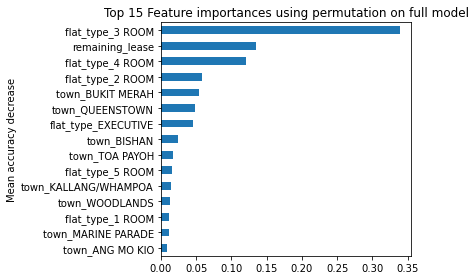

In [180]:
fig, ax = plt.subplots()
forest_importances.sort_values()[-15:].plot.barh(ax=ax)
ax.set_title("Top 15 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Finally as seen above we can tell which factors have the largest impact on the prices of houses in 2014 which is whether they are a 3 room HDB is more relevant than the age of the HDB according to this model

---
---

# *Question B:*   
A flat was sold in Nov 2017 with the following characteristics:
- Flat type: 4 ROOM
- Town: Yishun
- Flat Model: New Generation
- Storey Range: 10 to 12
- Floor Area (sqm): 91
- Lease Commence Date: 1984
- Resale Price: 550,800  

Was this a reasonable price for the transaction? How confident are you in your assessment?

---

### Initial analysis

If plot the houses transacted for similar
1. year price 
2. size of home
3. age of the home
4. town

we see that the price paid for the house is in excess of the sample expectations

In [202]:
df_search = df[(df['month'].dt.year==2017)\
   &(df['flat_type']=='4 ROOM')\
   &(df['floor_area_sqm'].between(90, 92))\
   &(df['remaining_lease'].between(63, 69))\
   &(df['town']=='YISHUN')]
# remove the test statistic
df_search = df_search[:-1]

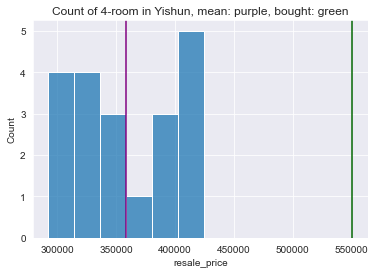

In [203]:
sns.histplot(data=df_search, x = 'resale_price')
plt.axvline(df_search.resale_price.mean(), 0,8,color='purple')
plt.axvline(550800, 0,8, color='darkgreen')
plt.title('Count of 4-room in Yishun, mean: purple, bought: green');

However this is still a small sample and there is a large data set to make a model and see if this transactions follows the expectation of the transacted prices. 

## Feature Engineering

As discussed during EDA portion there is an outlier, we will impute the correct value with commencement date and 99 year lease

In [117]:
df['remaining_lease'] = df['remaining_lease'].replace([0],42)

In [118]:
df.lease_commence_date = df.lease_commence_date.dt.year
df['transact_month'] = df.month.dt.month
df['transact_year'] = df.month.dt.year

Drop the following columns because they are dependent or highly correlated:  
'month','storey_range','block','storey_lower','storey_upper','flat_age','address'


In [119]:
df.drop(columns=['month','storey_range','block','storey_lower','storey_upper'],inplace=True)

In [120]:
numeric_feat =[col for col in df.columns if df[col].dtypes != 'O'and col not in ['_id']]
discrete_feat = [col for col in numeric_feat if len(df[col].unique())<25 and col not in ['_id']]
continuous_feat = [col for col in numeric_feat if col not in discrete_feat and col not in ['_id']]
categorical_feat = [col for col in df.columns if df[col].dtypes == 'O']

## skewness

In [121]:
# check the skew of all numerical features
print('====SKEWNESS====')
for feat in numeric_feat:
    print(f'{feat}\t\t{df[feat].skew():.3f}')

====SKEWNESS====
floor_area_sqm		0.374
resale_price		0.845
remaining_lease		-0.677
lease_commence_date		0.510
block_num		0.544
storey_ave		1.249
transact_month		-0.040
transact_year		0.310


very skewed for all except transaction month, but they will be scaled any way. There is skew in the resale_price but we'll deal with that later

In [122]:
# after review it may only make sense to transform remaining_lease
# because the other features are just descriptive
power = PowerTransformer(method='box-cox', standardize=True)
df['remaining_lease'] = power.fit_transform(df['remaining_lease'])

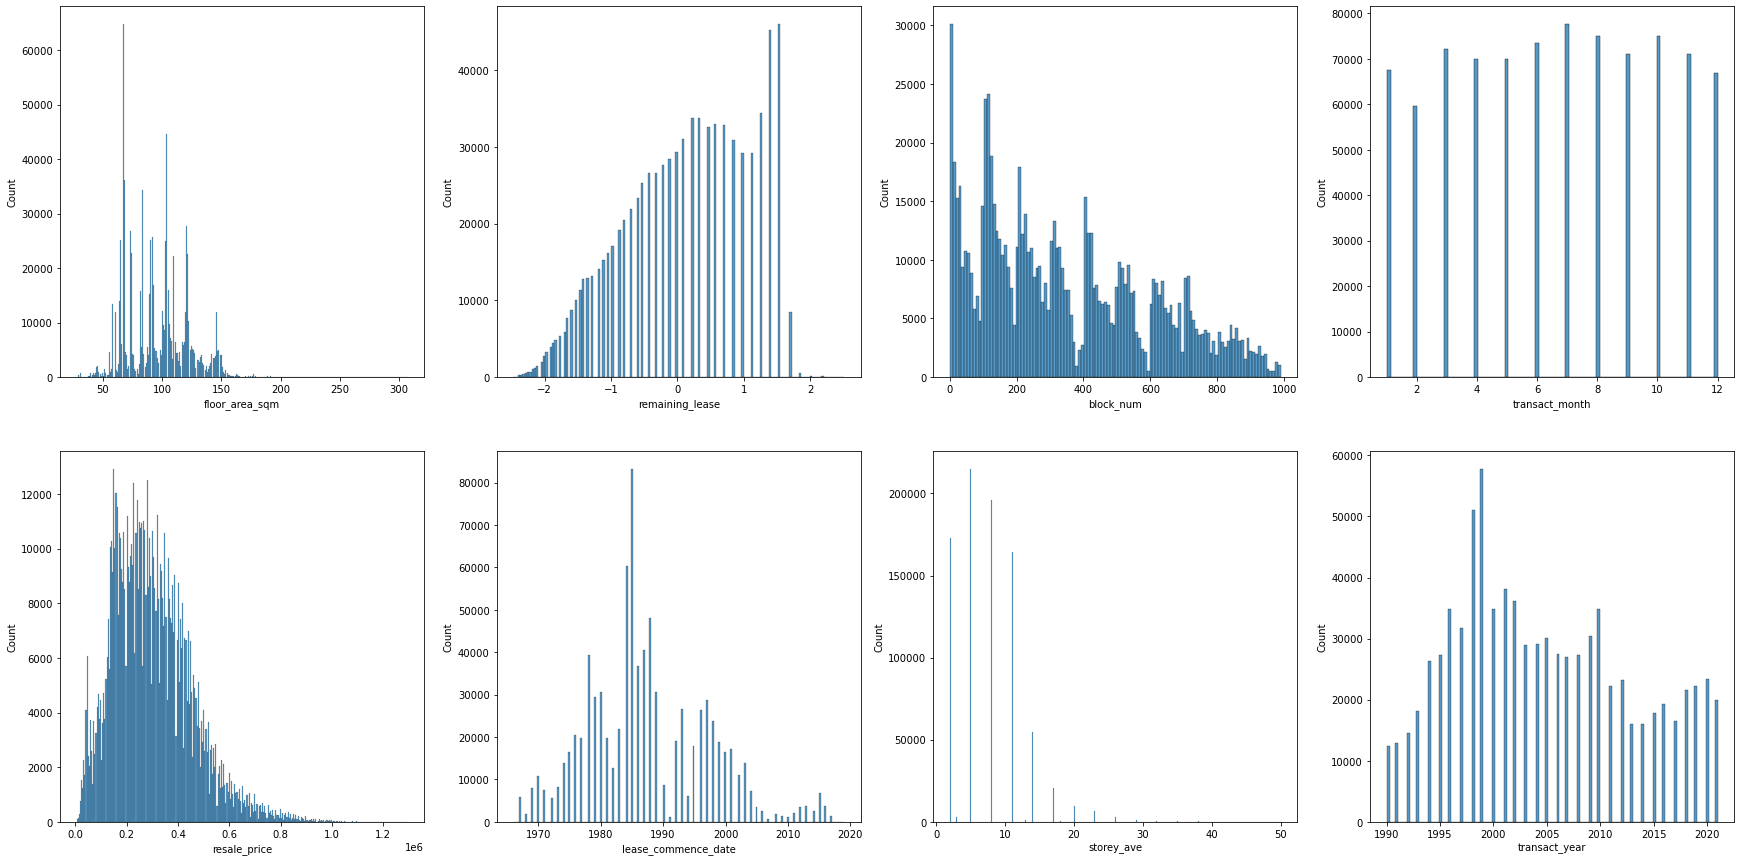

In [146]:
f, axes = plt.subplots(2,4 , figsize=(30, 15), sharex=False)
for i, feature in enumerate(numeric_feat):
    sns.histplot(data=df, x = feature,ax=axes[i%2, i//2])

### Get dummies

In [123]:
df = pd.get_dummies(df).reset_index(drop=True)
df.shape

(849759, 651)

there is still more data than columns, this is still a good format for regression models

In [95]:
# create csv for future use
df.to_csv('./data/df2.csv',index=False)

KeyboardInterrupt: 

### Create train and test data

`y` is going to be transformed. The reason is that we want the target distribution to be normal

In [96]:
df = pd.read_csv('./data/df2.csv')

In [125]:
# we need to ensure that 'test' is added to the y_train
test = df[-1:]
df = df[:-1]

In [126]:
# split to X and y
X = df.drop(columns=['resale_price'])
y = np.log1p(df['resale_price'])

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=42)

In [99]:
X_test = X_test.append(test.drop(columns='resale_price'))
y_test = y_test.append(np.log1p(test['resale_price']))

In [100]:
pre_precessing_pipeline = make_pipeline(RobustScaler(),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(49315, 650)
(49317, 650)


### Random Forest

This allows for ensemble, random subset selection and Bagging  
Use RF with initial model from Section 2.A but GridSearch is not used because of the length of time to get the result

In [296]:
rf1 = RandomForestRegressor(random_state=42, max_depth=100,n_estimators=400,max_samples = 0.5, warm_start=True, max_features = 'log2')
rf1.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, max_features='log2', max_samples=0.5,
                      n_estimators=400, random_state=42, warm_start=True)

In [297]:
y_pred = np.expm1(rf1.predict(X_train))
rf1_mse = mean_squared_error(np.expm1(y_train), y_pred)
print(f'train rmse\t\t{rf1_mse**.5:,.0f}')

train rmse		18758.920582119194


### Random Forest Evaluating Model

In [ ]:
y_pred = np.expm1(rf1.predict(X_test))
rf1_mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'test rmse\t\t{rf1_mse**.5:,.0f}')

### Final Prediction Model

In [135]:
# create final model by fitting against entire dataset
# First we remove the test sample and transform X

X = pre_precessing_pipeline.fit_transform(X[:-1])
y = y[:-1]

rf3 = RandomForestRegressor(random_state=42, 
                            max_depth=100,
                            n_estimators=400,
                            max_samples = 0.5, 
                            warm_start=True, 
                            max_features = 'log2')
# fit entire data set and predict the test house price
rf3.fit(X,y)

y_pred = np.expm1(rf3.predict(X_test))

In [142]:
y_pred = np.expm1(rf3.predict(X))
rf3_mse = mean_squared_error(np.expm1(y), y_pred)
print(f'train rmse\t\t{rf3_mse**.5:,.0f}')

train rmse		16,975


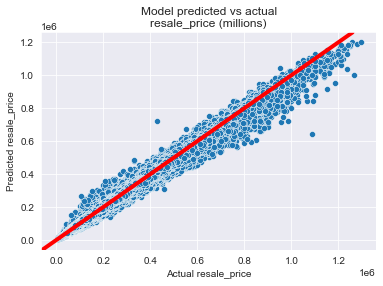

In [223]:
ax = sns.scatterplot(x =np.expm1(y) ,y=y_pred)
ax.axline((0, 0), (1, 1), linewidth=4, color='r')
ax.set(xlabel='Actual resale_price', ylabel='Predicted resale_price')
plt.title('Model predicted vs actual\nresale_price (millions)')
plt.show();

The model chose is reasonably accurate however for lower prices the is a positive bias and the opposite for the higher prices. There may be polynomial terms that is missed in the model. However this should be sufficient in accessing ther proposed purchase price of the home in Yishun

In [136]:
print(f'the model predicted sale price is {y_pred[-1]:,.0f}')

the model predicted sale price is 457,882


In [137]:
# save best model
dump(rf1, './data/best_model.joblib')

['./data/best_model.joblib']

# Section 2 B Conclusion
The model provided is targeted at ~ 458,000 with a confidence interval of 16,975. Meaning that the model expects around a maximum price of around 474,857. so it would be unreasonable to pay 550,800 for a 4 ROOM HDB in Yishun. Provided that it is an MSE and regression was used here and all assumptions hold, there should be a 95% confidence that this prediction is reasonable.

With regard to feature importance, we see that transact year plays a big role and size of the  apartment plays an outsized role in the price. And based on the the initial analysis the proposed resale_price would not be expected based on historical prices

In [305]:
forest_importances = pd.Series(rf3.feature_importances_, index=X.columns)

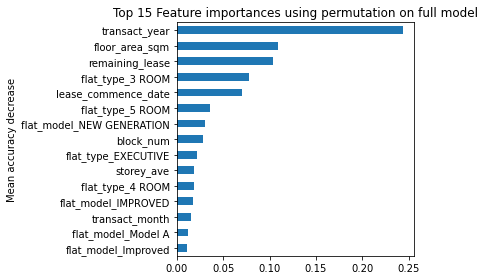

In [306]:
fig, ax = plt.subplots()
forest_importances.sort_values()[-15:].plot.barh(ax=ax)
ax.set_title("Top 15 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

---
---
# Section 2, Question C***: 

Someone mistakenly deleted the column containing data on ***Flat Type*** in the database. While backups exist, these data are critical to HDB’s daily operations, and time would be needed to restore these data from the backup. Senior management would like you to create a model to predict flat type given a transaction’s other characteristics. Explain the reasons for choosing this model.

### Initial Analysis
What are the relationships bewteen flat_type and the remainder of features

In [59]:
# extract dataset
df_cat = pd.read_csv('hdb_resale.csv')

/Users/Ju/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
numeric_feat =[col for col in df_cat.columns if df_cat[col].dtypes != 'O'and col not in ['_id']]
discrete_feat = [col for col in numeric_feat if len(df_cat[col].unique())<25 and col not in ['_id']]
continuous_feat = [col for col in numeric_feat if col not in discrete_feat and col not in ['_id']]
categorical_feat = [col for col in df_cat.columns if df_cat[col].dtypes == 'O']

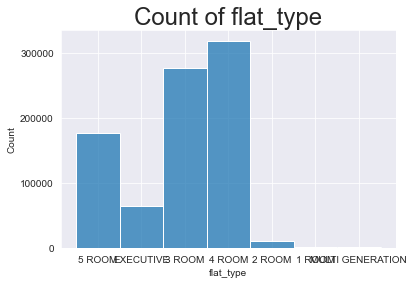

In [8]:
sns.histplot(data=df_cat, x = 'flat_type')
sns.set(font_scale=2)
plt.title('Count of flat_type');

In [153]:
1984+99-2017

66

There is high imbalance in the classifications 
- 4 Room is the highest at 38%
- 3 room is the next highest at 33%
- 3 to 5 Room take up >90% of classifications  

over sampling might not be relevant here and instead a baseline can be created.  
will run analysis without over or synthetic sampling first. but will take note of accuracy and establish a baseline for assessment

4 ROOM              0.375535
3 ROOM              0.326369
5 ROOM              0.208083
EXECUTIVE           0.075925
2 ROOM              0.011969
1 ROOM              0.001510
MULTI GENERATION    0.000608
Name: flat_type, dtype: float64

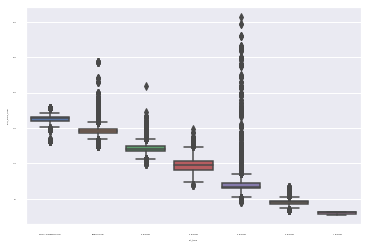

In [39]:
sort_list = sorted(df.groupby('flat_type')['floor_area_sqm'].median().items(), key= lambda x:x[1], reverse = True)
order_list = [x[0] for x in sort_list ]
sns.boxplot(data = df, x = 'flat_type', y='floor_area_sqm', order=order_list)
sns.set(font_scale=.2)
df_cat['flat_type'].value_counts(normalize=True)

In [25]:
df_cat[['flat_type','flat_model']].value_counts(normalize=True).sort_index()

flat_type         flat_model            
1 ROOM            IMPROVED                  0.001510
2 ROOM            2 ROOM                    0.000033
                  2-ROOM                    0.000025
                  DBSS                      0.000001
                  IMPROVED                  0.003016
                  MODEL A                   0.001165
                  PREMIUM APARTMENT         0.000059
                  STANDARD                  0.007670
3 ROOM            ADJOINED FLAT             0.000002
                  DBSS                      0.000307
                  IMPROVED                  0.090595
                  MODEL A                   0.056477
                  NEW GENERATION            0.138223
                  PREMIUM APARTMENT         0.000723
                  SIMPLIFIED                0.015697
                  STANDARD                  0.023642
                  TERRACE                   0.000703
4 ROOM            ADJOINED FLAT             0.000202
     

main considerations 
- flat_model
- resale_price
- flat_size_sqm
- storey_ave 
- town

### Address skew of resale price

In [69]:
# create features first
df_cat = df_cat[['flat_model','resale_price','floor_area_sqm','storey_ave']]

KeyError: "['flat_model'] not in index"

In [73]:
# after review it may only make sense to transform remaining_lease
# because the other features are just descriptive
df_cat[['resale_price']] = power.fit_transform(df_cat[['resale_price']])

### Get dummies

In [74]:
df_cat = pd.get_dummies(df_cat).reset_index(drop=True)
df_cat.shape

(849758, 23)

In [75]:
df.shape

(849758, 15)

## Create X and Y
`y` is going to be transformed. The reason is that we want the target distribution to be normal

In [76]:
# split to X and y
X = df_cat
y = df['flat_type']

# split train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.5,
                                                    random_state=42)

In [77]:
pre_precessing_pipeline = make_pipeline(RobustScaler(),
                                       )

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(424879, 23)
(424879, 23)


In [ ]:
= LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [78]:
# try decision tree, random forest and log reg
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train,y_train)


DecisionTreeClassifier(random_state=42)

In [79]:
dt.score(X_train, y_train), dt.score(X_test, y_test)

(0.999169175224005, 0.9957540852807505)

In [80]:
cross_val_score(dt,X,y, cv=10)

array([0.99463378, 0.99404538, 0.99577528, 0.99649313, 0.99521041,
       0.9919389 , 0.99172708, 0.98665506, 0.99581053, 0.99710503])

In [83]:
# predict
y_pred = dt.predict(X_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

In [124]:
cm_df = pd.DataFrame(cm,columns=dt.classes_,index=dt.classes_)
cm_df.to_csv('./results/2c_confusion_matrix.csv',index=False)

In [121]:
plt.rcParams.update({'font.size': 10})

<Figure size 7200x7200 with 0 Axes>

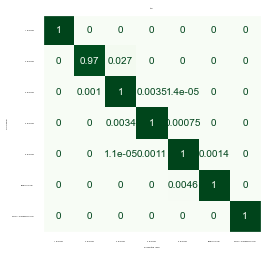

In [123]:
#Plotting the confusion matrix
plt.figure(figsize=(100,100))
plot_confusion_matrix(dt, X_test, y_test, cmap='Greens', colorbar=False
                      , normalize='true')
plt.grid(False)
plt.title('title');

### unsupervised classification
Assuming there is no training data a is required. K means is used

In [126]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Although there are 7 flat_types, we take a k of 4 because the smaller flat sizes will likely make classifying the remainder of samples difficult

In [143]:
# with kmeans, we fit the entire dataset
km = KMeans(n_clusters=4, random_state=42)
km.fit(X)

KMeans(n_clusters=4, random_state=42)

In [144]:
df['k_labels'] = km.labels_

In [146]:
df[['flat_type','k_labels']].value_counts(normalize=True).sort_index()

flat_type         k_labels
1 ROOM            1           0.001510
2 ROOM            1           0.011969
3 ROOM            0           0.000139
                  1           0.305413
                  2           0.020638
                  3           0.000180
4 ROOM            0           0.023689
                  1           0.001418
                  2           0.350295
                  3           0.000133
5 ROOM            0           0.190215
                  2           0.000816
                  3           0.017052
EXECUTIVE         0           0.005196
                  3           0.070730
MULTI GENERATION  0           0.000045
                  3           0.000564
dtype: float64

A GridSearch is used to validate the value of k. A smaller sample of X i.e. X_train is used to train the model to reduce compute time

In [150]:
scores = []
for k in range(2, 7):
    cl = KMeans(n_clusters=k)
    cl.fit(X_train)
    inertia = cl.inertia_
    sil = silhouette_score(X_train, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [162]:
plt.rcParams.update({'font.size': .000001})

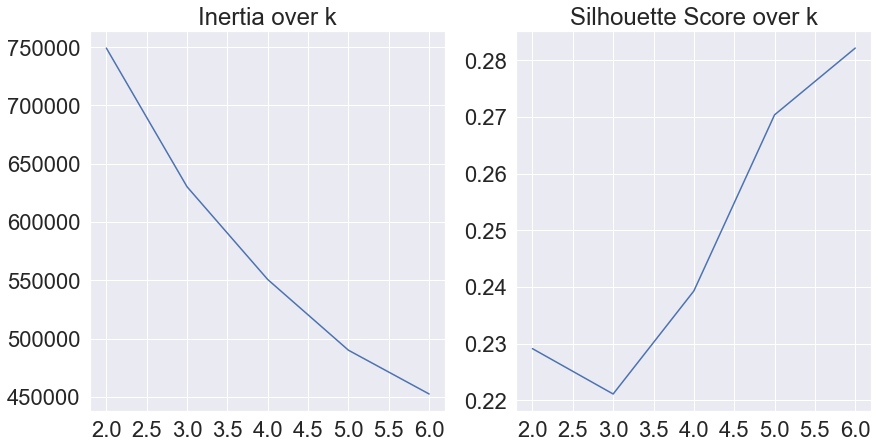

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')
sns.set()

# Section 2 Question C Conclusion
Yes, using a training set a the room types can be segregated easily

As seen there is a good silhouette score at k =3 likely due to 3room grouped with 1,2room and 5room grouped with exec,multi generation. it is possible to perform unsupervised grouping but as the model coerces the divisions the accuracy decreases. As seen in the Silhouette Score over k graph after k = 3

# Section 3: Policy Analysis

HDB is considering and reviewing a slew of policies, and wants to adopt an evidence-based approach to evaluate these policies.

#### Question A*: Yishun has received a negative reputation as “Crazy Town”, and property prices might have been impacted. Are Yishun flats the cheapest in the country?

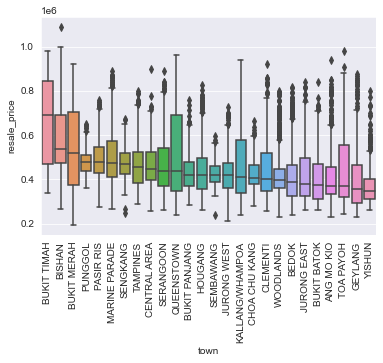

<Figure size 7200x2160 with 0 Axes>

In [14]:
sort_list = sorted(df_2014.groupby('town')['resale_price'].median().items(), key= lambda x:x[1], reverse = True)
order_list = [x[0] for x in sort_list ]
sns.boxplot(data = df_2014, x = 'town', y='resale_price', order=order_list)
plt.xticks(rotation='vertical')
plt.figure(figsize=(100, 30))
plt.show();

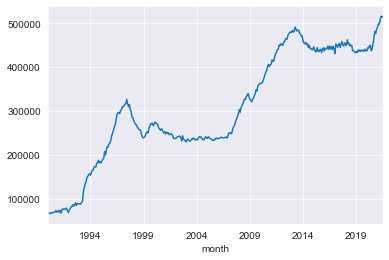

In [22]:
df[df['town']!='YISHUN'].groupby(['month'])['resale_price'].mean().plot();

<AxesSubplot:xlabel='month'>

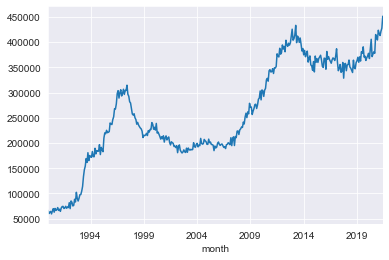

In [23]:
df[df['town']=='YISHUN'].groupby(['month'])['resale_price'].mean().plot()

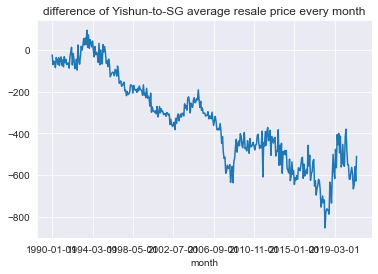

In [49]:
df[df['town']=='YISHUN'].groupby('month')['resale_delta'].mean().plot()
plt.title('difference of Yishun-to-SG average resale price every month');

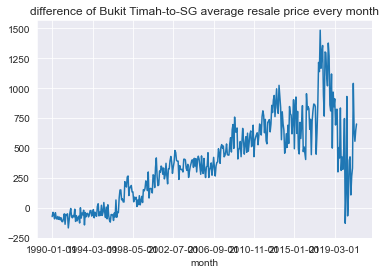

In [52]:
df[df['town']=='BUKIT TIMAH'].groupby('month')['resale_delta'].mean().plot()
plt.title('difference of Bukit Timah-to-SG average resale price every month');

Question B*: Some members of public have been saying that flat sizes have gotten smaller over the
years. Is there any truth in this statement?

In [37]:
df.columns.to_list()

['town',
 'flat_type',
 'flat_model',
 'floor_area_sqm',
 'street_name',
 'resale_price',
 'month',
 'remaining_lease',
 'lease_commence_date',
 'storey_range',
 'block',
 'storey_lower',
 'storey_upper',
 'block_num',
 'storey_ave',
 'month_mean',
 'resale_delta',
 'px_per_sqm']

<AxesSubplot:xlabel='lease_commence_date'>

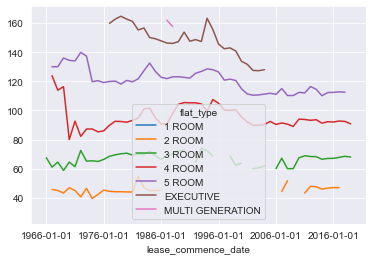

In [40]:
df.groupby(['flat_type','lease_commence_date'])['floor_area_sqm'].mean().unstack().T.plot()

Question C**: The Downtown Line Stage 2 connects the Bukit Panjang heartland to the city. Have
prices increased for resale flats in the towns served by this Line? You might want to use a differencein-
differences model for this task.

In [29]:
df['px_per_sqm'] = df['resale_price']/df['floor_area_sqm']

<AxesSubplot:xlabel='month'>

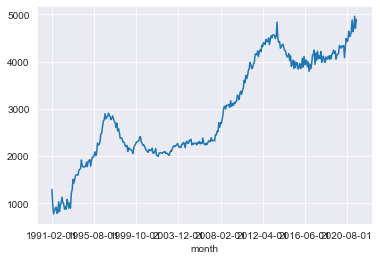

In [30]:
df[df['town']=='BUKIT PANJANG'].groupby(['month'])['px_per_sqm'].mean().plot()

In [31]:
df_month_mean = df.groupby(['month'])['px_per_sqm'].mean()

In [32]:
df['month_mean'] = df['month'].apply(lambda x: df_month_mean[x])

In [33]:
df['resale_delta'] = df['px_per_sqm'] - df['month_mean']

<AxesSubplot:xlabel='month'>

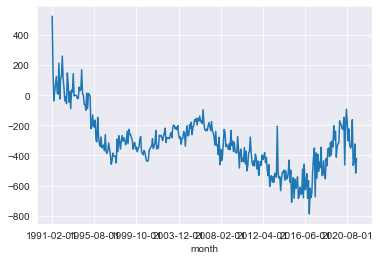

In [34]:
df[df['town']=='BUKIT PANJANG'].groupby('month')['resale_delta'].mean().plot()

Question D***: There have been comments online that people are buying flats in towns further from
the city so that the cost savings can be used for a car. Are resale prices in HDB estates in areas further
away from the city (i.e. Sengkang and Punggol) impacted by Certificate of Entitlement (COE) prices for
cars?

Correlation?
plot coe and price per sqm for sengkang and punggol

------
---
---
---
---
---

# Appendix A: 
Trying  a gridsearch for Question 2 Section B shows that even with a high number of  estimators the performance wasnt as good as the final choice. but there is further analysis as below

In [307]:
rf = RandomForestRegressor(random_state=42, max_samples = 0.5, warm_start=True, max_features = 'log2')

rf_params = {
    'n_estimators': [64,100],
    'max_depth': [25]
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5,n_jobs=-1,scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

print(gs.cv_results_)
print(gs.best_params_)
print(f'train rmse: {abs(gs.best_score_)**.5:,.0f}')

{'mean_fit_time': array([411.11420593, 387.27076974]), 'std_fit_time': array([46.10733007, 88.27453196]), 'mean_score_time': array([ 6.05605621, 10.41911221]), 'std_score_time': array([1.88905101, 2.40712863]), 'param_max_depth': masked_array(data=[25, 25],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[64, 100],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 25, 'n_estimators': 64}, {'max_depth': 25, 'n_estimators': 100}], 'split0_test_score': array([-0.09461742, -0.09881014]), 'split1_test_score': array([-0.09221527, -0.09825562]), 'split2_test_score': array([-0.09231915, -0.09438016]), 'split3_test_score': array([-0.09117601, -0.09254972]), 'split4_test_score': array([-0.08818203, -0.08926433]), 'mean_test_score': array([-0.09170197, -0.09465199]), 'std_test_score': array([0.00208858, 0.00357202]), 'rank_test_score': array([1, 2], dtype=int32)}


In [308]:
y_pred = np.expm1(gs.predict(X_train))
gs_mse = mean_squared_error(np.expm1(y_train), y_pred)
print(f'train rmse\t\t{gs_mse**.5}')

train rmse		89492.36594562394


In [157]:
test

,floor_area_sqm,resale_price,remaining_lease,lease_commence_date,block_num,storey_ave,transact_month,transact_year,town_ANG MO KIO,town_BEDOK,...,street_name_YISHUN ST 72,street_name_YISHUN ST 81,street_name_YUAN CHING RD,street_name_YUNG AN RD,street_name_YUNG HO RD,street_name_YUNG KUANG RD,street_name_YUNG LOH RD,street_name_YUNG PING RD,street_name_YUNG SHENG RD,street_name_ZION RD
849758,91.0,550800.0,-1.474529,1984,11,11.0,11,2017,0,0,...,0,0,0,0,0,0,0,0,0,0


In [309]:
y_pred = np.expm1(gs.predict(X_test))
gs_mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'train rmse\t\t{gs_mse**.5}')

train rmse		89906.51228499843
